# Optic flow connectivity analysis in FAFB

This script is about getting optic flow vectors in the medulla based on the main inputs of direction-selective cells in the medulla

In [1]:
# Importing some packages
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import pandas as pd
import os
from fafbseg import flywire

C:\Users\smolina\Anaconda3\envs\EM2\lib\site-packages\blessed\terminal.py:183: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


In [2]:
# Custom functions
def combine_xyz(df):
    """
    Combines separated x, y and z column into one, changes units and adds new column names for
    generating a neuroglancer link with function nglui.statebuilder.helpers.make_synapse_neuroglancer_link

    Args:
        pandas data frame containing x,y and z as columns of the same length

    Returns:
        same pandas data frame containing a new column with [x/4,y/4,z/40] lists
    """
    # Generating the single column

    post_pt_position = []
    for x,y,z in zip(df['post_x'].tolist(),df['post_y'].tolist(),df['post_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        post_pt_position.append(temp_ls)

    pre_pt_position = []
    for x,y,z in zip(df['pre_x'].tolist(),df['pre_y'].tolist(),df['pre_z'].tolist()):
        temp_ls = [x/4,y/4,z/40]
        pre_pt_position.append(temp_ls)

    #Adding new columns and names
    df['post_pt_position'] = post_pt_position
    df['pre_pt_position'] = pre_pt_position
    #Changing column names
    df.rename(columns={'pre': 'pre_pt_root_id', 'post': 'post_pt_root_id'}, inplace=True)

# 1. Getting the data of interest

In [3]:
# Some user parameters
cell_for_grid = 'Mi1'

In [4]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_columns.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_data = pd.read_csv(filePath, compression='gzip')
columns_id_data.rename(columns={"cell id": "root_id","cell type": "cell_type","column id": "column_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_metadata.csv.gz'
filePath = os.path.join(dataPath,fileName)
metadata = pd.read_csv(filePath, compression='gzip')

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'ol_connections.csv.gz'
filePath = os.path.join(dataPath,fileName)
connections = pd.read_csv(filePath, compression='gzip')
connections.rename(columns={"from cell id": "from_cell_id","to cell id": "to_cell_id" }, inplace= True)

dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'column_assignment.csv.gz'
filePath = os.path.join(dataPath,fileName)
columns_id_coordinates = pd.read_csv(filePath, compression='gzip')

#Brief overview:
print('\n----------------- column data -----------------:\n')
print(columns_id_data)

print('\n------------------ metadata ------------------:\n')
print(metadata)
print('\n----------------- connections ----------------:\n')
print(connections)
print('\n----------------- coordinates ----------------:\n')
print(columns_id_coordinates)


----------------- column data -----------------:

                  root_id cell_type column_id
0      720575940596125868       T5c        97
1      720575940599333574       Tm1       355
2      720575940599457990       T4b       247
3      720575940599459782       T5b       513
4      720575940599704006       T5a       331
...                   ...       ...       ...
23447  720575940661201025        R8       701
23448  720575940661224065       T4a       390
23449  720575940661245825        C3       183
23450  720575940661264001        C3        38
23451  720575940661284993        R8       694

[23452 rows x 3 columns]

------------------ metadata ------------------:

                 attribute    value
0   number of cells mapped    22578
1  synapses inside columns  1381915
2   synapses cross columns   811545

----------------- connections ----------------:

              from_cell_id          to_cell_id  synapses
0       720575940596125868  720575940622955561         2
1       72057

## 1.1 Combining the data of interest into useful data frames

In [5]:
## Completing the "connections" data frame

connections_extended = connections.copy()

# Merge to add from_cell_type
connections_extended = connections_extended.merge(
    columns_id_data[['root_id', 'cell_type','column_id']],
    how='left',
    left_on='from_cell_id',
    right_on='root_id'
).rename(columns={'cell_type': 'from_cell_type','column_id': 'from_column_id'}).drop(columns=['root_id'])

# Merge to add to_cell_type
connections_extended = connections_extended.merge(
    columns_id_data[['root_id', 'cell_type','column_id']],
    how='left',
    left_on='to_cell_id',
    right_on='root_id'
).rename(columns={'cell_type': 'to_cell_type','column_id': 'to_column_id'}).drop(columns=['root_id'])

# Display the updated connections data frame
print(connections_extended)

              from_cell_id          to_cell_id  synapses from_cell_type  \
0       720575940596125868  720575940622955561         2            T5c   
1       720575940599333574  720575940617904614         7            Tm1   
2       720575940599333574  720575940629129692        22            Tm1   
3       720575940599333574  720575940612157041        11            Tm1   
4       720575940599333574  720575940609269771         4            Tm1   
...                    ...                 ...       ...            ...   
270851  720575940661264001  720575940613285034         3             C3   
270852  720575940661264001  720575940647104291        87             C3   
270853  720575940661264001  720575940638965155        17             C3   
270854  720575940661284993  720575940628173394         3             R8   
270855  720575940661284993  720575940624106948         7             R8   

       from_column_id to_cell_type to_column_id  
0                  97          T5c          443  

In [6]:
connections_extended.from_cell_type.unique()

array(['T5c', 'Tm1', 'T4b', 'T5b', 'T5a', 'T4a', 'Tm9', 'Mi9', 'T4c',
       'T5d', 'T4d', 'Tm3', 'T3', 'T2a', 'L1', 'T2', 'Mi4', 'Mi1', 'Tm2',
       'Tm4', 'C2', 'L4', 'Tm20', 'L5', 'C3', 'Tm21', 'L3', 'L2', 'R7',
       'T1', 'R8'], dtype=object)

# 2. Creating the hexagonal grid

## 2.1 Getting the cells of reference (usually Mi1s) for creating a 2D lattice

In [7]:
# Looking deeply at the match between individual cells and individual columns
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_for_grid]
number_unique_cells = len(cells_columns['root_id'].unique())
number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label"

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df_grid =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df_grid length: {len(df_grid)}')
display(df_grid.head())

Total number of unique cells: 796
Total number of unique columns: 795
Missmatch: 1
Number of duplicates / cells not assigned to columns: 0
Filtered data length: 796
Final df_grid length: 796


,root_id,cell_type,column_id,p,q,x,y
0,720575940603042272,Mi1,1,12,1,6,13
1,720575940603200428,Mi1,2,9,-7,8,2
2,720575940603327916,Mi1,3,-12,0,-6,-12
3,720575940603935334,Mi1,4,-6,-15,5,-21
4,720575940604151008,Mi1,6,0,-4,2,-4


## 2.2 Importing other more data about the cells of interest

In [8]:
# Importing data from Codex
dataPath = R'D:\Connectomics-Data\FlyWire\Codex-datasets'
fileName = 'labels.csv.gz'
filePath = os.path.join(dataPath,fileName)
labels_data = pd.read_csv(filePath, compression='gzip')

In [9]:
df2 = pd.merge(labels_data, columns_id_data, on='root_id', how='outer')
filtered_df2  = df2.drop_duplicates(subset='root_id', keep='first').copy()
mi1_df2 = filtered_df2[filtered_df2['cell_type'] == 'Mi1'].copy()
display(mi1_df2.head())

,root_id,label,user_id,position,supervoxel_id,label_id,date_created,user_name,user_affiliation,cell_type,column_id
192,720575940603042272,Mi1; Medullary intrinsic neuron 1; FBbt_00003776,392.0,[739864 206272 81960],8.331962e+16,76738.0,2023-01-31 22:14:43,Krzysztof Kruk,Eyewire,Mi1,1
238,720575940603200428,Mi1; Medullary intrinsic neuron 1; FBbt_00003776,392.0,[709316 297120 66680],8.282855e+16,77514.0,2023-02-01 14:00:22,Krzysztof Kruk,Eyewire,Mi1,2
272,720575940603327916,Mi1; Medullary intrinsic neuron 1; FBbt_00003776,392.0,[833308 358980 202680],8.494071e+16,76614.0,2023-01-31 22:14:34,Krzysztof Kruk,Eyewire,Mi1,3
631,720575940603935334,Mi1; Medullary intrinsic neuron 1; FBbt_00003776,392.0,[684784 347004 123280],8.240723e+16,76740.0,2023-01-31 22:14:44,Krzysztof Kruk,Eyewire,Mi1,4
782,720575940604151008,Mi1; Medullary intrinsic neuron 1; FBbt_00003776,392.0,[771472 320404 81080],8.388449e+16,77389.0,2023-02-01 14:00:10,Krzysztof Kruk,Eyewire,Mi1,6


In [10]:
#checking numbers with Mi1 example
print('Number of unique Mi1 ids in df2: ')
print(len(df2[df2['cell_type'] == 'Mi1'].root_id.unique()))
print('Number of  Mi1 ids in filtered_df2: ')
print(len(filtered_df2[filtered_df2['cell_type'] == 'Mi1'].root_id))


Number of unique Mi1 ids in df2: 
796
Number of  Mi1 ids in filtered_df2: 
796


In [11]:
# Getting Mi1s positions (soma locations)

# Convert positions to NumPy array for easier manipulation
positions_somas = np.array(mi1_df2.position.values) # These are apparently soma locations!
positions_somas = np.array([list(map(int, pos.strip('[]').split())) for pos in positions_somas])

In [ ]:
## Getting Mi1 positions (terminals)

'''
All in a loop across mi1 cells:
1. Getting pre-synaptic sites
2. PCA to get the depth axis of each Mi1
3. Select the last points belonging to layer M9-10
4. Calculate a centroid
5. Define this centroid as the Mi1 terminal location
'''
# Getting pre-synaptic sites
terminal_position_ls = []
curr_id_ls = mi1_df2.root_id.tolist()
output_df2 = flywire.synapses.get_synapses(curr_id_ls, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True)

In [ ]:
# PCA to get the depth axis of each Mi1
combine_xyz(output_df2)
for root_id in mi1_df2.root_id:
    # Getting single Mi1 re synaptic sites
    curr_df2 = output_df2[output_df2.pre_pt_root_id == int(root_id)]
    positions_pre_syn = np.array(curr_df2.pre_pt_position.values)
    positions_pre_syn = np.array([list(map(int, pos.strip('[]').split())) for pos in positions_pre_syn])

    #Doing PCA
    
    pass

# Seb coding here

In [ ]:
output_df2.head()

In [ ]:
# Quick visualization

import plotly.graph_objs as go

# Extract x, y, z coordinates
x = positions_somas[:, 0]
y = positions_somas[:, 1]
z = positions_somas[:, 2]

# Create the 3D scatter plot
trace = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(size=5, color='blue')
)

layout = go.Layout(
    title='3D Scatter Plot of Positions',
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Z Position'
    )
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()




In [ ]:
# Checking positions relative to the medulla neuropile

import navis
neurpile_mesh = 'ME_L'

#For top view
mesh_azim =16# -18 for ME_R, 16 (600) for ME_L
mesh_elev = -50 # -148 for ME_R, -50 (-489) for ME_L 

# Extract x, y, z coordinates
x = positions_somas[:, 0]
y = positions_somas[:, 1]
z = positions_somas[:, 2]

# Create a 3D scatter plot

fig = plt.figure()
ax  = fig.add_subplot(projection='3d')

#Plot the mesh
OL_R = flywire.get_neuropil_volumes([neurpile_mesh]) #['ME_R','LO_R','LOP_R']
navis.plot2d([OL_R], method='3d_complex', ax=ax,view=(172, 51),scalebar = '20 um')

ax.azim = mesh_azim
ax.elev = mesh_elev

# Plot the data
ax.scatter(x, y, z, c='b', marker='o')

# Set labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')

# Set title
ax.set_title('3D Scatter Plot of Positions')

plt.show()

## 2.3 Getting the cells of interest (usually a T4 subtype) for optic flow analysis

In [8]:
# Looking deeply at the match between individual cells and individual columns
cell_of_interest = 'T4a'
cells_columns = columns_id_data[columns_id_data['cell_type'] == cell_of_interest]
number_unique_cells = len(cells_columns['root_id'].unique())
number_unique_columns = len(cells_columns['column_id'].unique())-1 #-1 to compensate for "not assigned label"

print(f'Total number of unique cells: {number_unique_cells}')
print(f'Total number of unique columns: {number_unique_columns}')
print(f'Missmatch: {number_unique_cells - number_unique_columns}')

# Identify duplicate values in 'column id'
duplicates = cells_columns[cells_columns.duplicated('column_id', keep=False)]

print(f'Number of duplicates / cells not assigned to columns: {len(duplicates)}')

# Filter out rows with repetitive values
filtered_cells_columns = cells_columns[~cells_columns['column_id'].isin(duplicates['column_id'])]
print(f'Filtered data length: {len(filtered_cells_columns)}')

# Addining column coordinates information
df =  pd.merge(filtered_cells_columns, columns_id_coordinates[['root_id', 'p', 'q', 'x', 'y']], on='root_id', how='left')
print(f'Final df length: {len(df)}')
display(df.head())

Total number of unique cells: 737
Total number of unique columns: 725
Missmatch: 12
Number of duplicates / cells not assigned to columns: 12
Filtered data length: 725
Final df length: 725


,root_id,cell_type,column_id,p,q,x,y
0,720575940599755718,T4a,741,-4,-8,2,-12
1,720575940600101641,T4a,487,-2,1,-1,-1
2,720575940600143369,T4a,662,-3,2,-2,-1
3,720575940600547529,T4a,727,-4,10,-7,6
4,720575940603491957,T4a,391,-6,3,-4,-3


# 3. Generating the 2D (hexagonal) grid/lattice

In [9]:
'''

important tasks to be done:

Refine the space between hexagons in the x-axis. 
More space is needed in between hexagons to have the same as in the other axis after the shift to get the honeycomb-like lattice.

'''

'\n\nimportant tasks to be done:\n\nRefine the space between hexagons in the x-axis. \nMore space is needed in between hexagons to have the same as in the other axis after the shift to get the honeycomb-like lattice.\n\n'

In [10]:
## Custom functions for creating the 2d lattice

def plot_hex_grid(x, y, hex_size=1.0, spacing=1.5, fig_size=(10, 10), labels=None, label_type='column_id', text_size=10):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.set_aspect('equal')
    
    hexagons = []
    
    # Function to calculate vertices of hexagon
    def hexagon_vertices(x_center, y_center):
        angles = np.linspace(0, 2*np.pi, 7) + np.pi/2  # Add pi/8 to rotate by 45 degrees
        vertices = [(x_center + hex_size * np.cos(angle), y_center + hex_size * np.sin(angle)) for angle in angles]
        return vertices
    
    # Plot hexagons
    for i in range(len(x)):
        vertices = hexagon_vertices(x[i], y[i])
        hexagon = Polygon(vertices, edgecolor='black', linewidth=1, facecolor='none')
        ax.add_patch(hexagon)
        hexagons.append(hexagon)
        
        # Determine label based on label_type
        if label_type == 'manual_labels' and labels:
            label = labels[i]
        elif label_type == 'xy':
            label = f'({x[i]}, {y[i]})'
        else:
            label = ''
        
        # Add label in the center of the hexagon
        if label:
            x_center = x[i]
            y_center = y[i]
            ax.text(x_center, y_center, label, ha='center', va='center', fontsize=text_size)
    
    # Set limits based on the hexagon positions
    ax.set_xlim(min(x) - hex_size - spacing, max(x) + hex_size + spacing)
    ax.set_ylim(min(y) - hex_size - spacing, max(y) + hex_size + spacing)
    
    ax.autoscale_view()
    
    return fig, ax, hexagons

def draw_vector(ax, x_start, y_start, x_end, y_end, linewidth=2, head_size=0.5, **kwargs):
    """Draw an arrow (vector) from one (x, y) coordinate to another with specified linewidth and arrowhead size."""
    arrow_style = f'->,head_width={head_size},head_length={head_size * 1.5}'
    arrow_style = f'-|>,head_width={head_size},head_length={head_size * 1.5}'
    ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                arrowprops=dict(arrowstyle=arrow_style, linewidth=linewidth, fill=True, **kwargs))


def calculate_new_p_values(original_x, original_y, start_key=-16, end_key=17, relative_change=0.5):
    shift_dict = {}

    # Iterate through the range from start_key to end_key (inclusive)
    for i in range(start_key, end_key + 1):
        # Calculate the corresponding value based on relative_change
        value = (i - start_key) * relative_change
        # Assign the key-value pair to the dictionary
        shift_dict[i] = value

    # Initialize a list to store the new_x values
    new_x_values = []

    # Iterate through each pair of original_x and original_y
    for x, y in zip(original_x, original_y):
        if y in shift_dict:
            # Get the corresponding relative_change from shift_dict
            relative_change = shift_dict[y]
            # Calculate the new_x value
            new_x = x - relative_change
            # Append the new_x value to the list
            new_x_values.append(new_x)
        else:
            # Handle case where y is not found in shift_dict (optional)
            # You may choose to skip these or handle them differently
            new_x_values.append(x)  # Keep original x value if no match found

    return new_x_values


In [90]:
## Preparing data to plot
#Important axis across the eye/medulla ( in terms of p,q coordinates)
'''
The ommatidia directions are well described by a hexagonal grid that we then aligned to the medulla column grid using 
the equator (+h) and central meridian (+v) as global landmarks
'''
h_x_ls = list(range(-8,8+1,1))
h_y_ls = list(range(8,-8-1,-1))
h = list(zip(h_x_ls,h_y_ls))

v_x_ls = list(range(-14,15+1,1))
v_y_ls = v_x_ls
v = list(zip(v_x_ls,v_y_ls))

p_y_ls = list(range(14,-13-1,-1))
p_x_ls = [0]* len(p_y_ls)
p = list(zip(p_x_ls,p_y_ls))

q_x_ls = list(range(-14,14+1,+1))
q_y_ls = [0]* len(q_x_ls)
q = list(zip(q_x_ls,q_y_ls))

'''
Seb, it would be good to calculate a new _new_x_ls and new_? 
(e.g., new_q_x_ls and new_q) using the function calculate_new_p_values
'''


# Given coordinates and labels (data)
# Original coordinates
original_p = df_grid.p.tolist()
original_q = df_grid.q.tolist()
new_p_values = calculate_new_p_values(original_p, original_q, start_key=-16, end_key=17, relative_change=0.5)
df_grid['new_p'] = new_p_values

# "manual_labels" column ids
labels = df_grid.column_id.tolist() 

# "manual_labels" original coordinates
#labels = list(zip(original_p, original_q)) 
#labels = [f"({x}, {y})" for x, y in labels]



### Ploting a regular grid

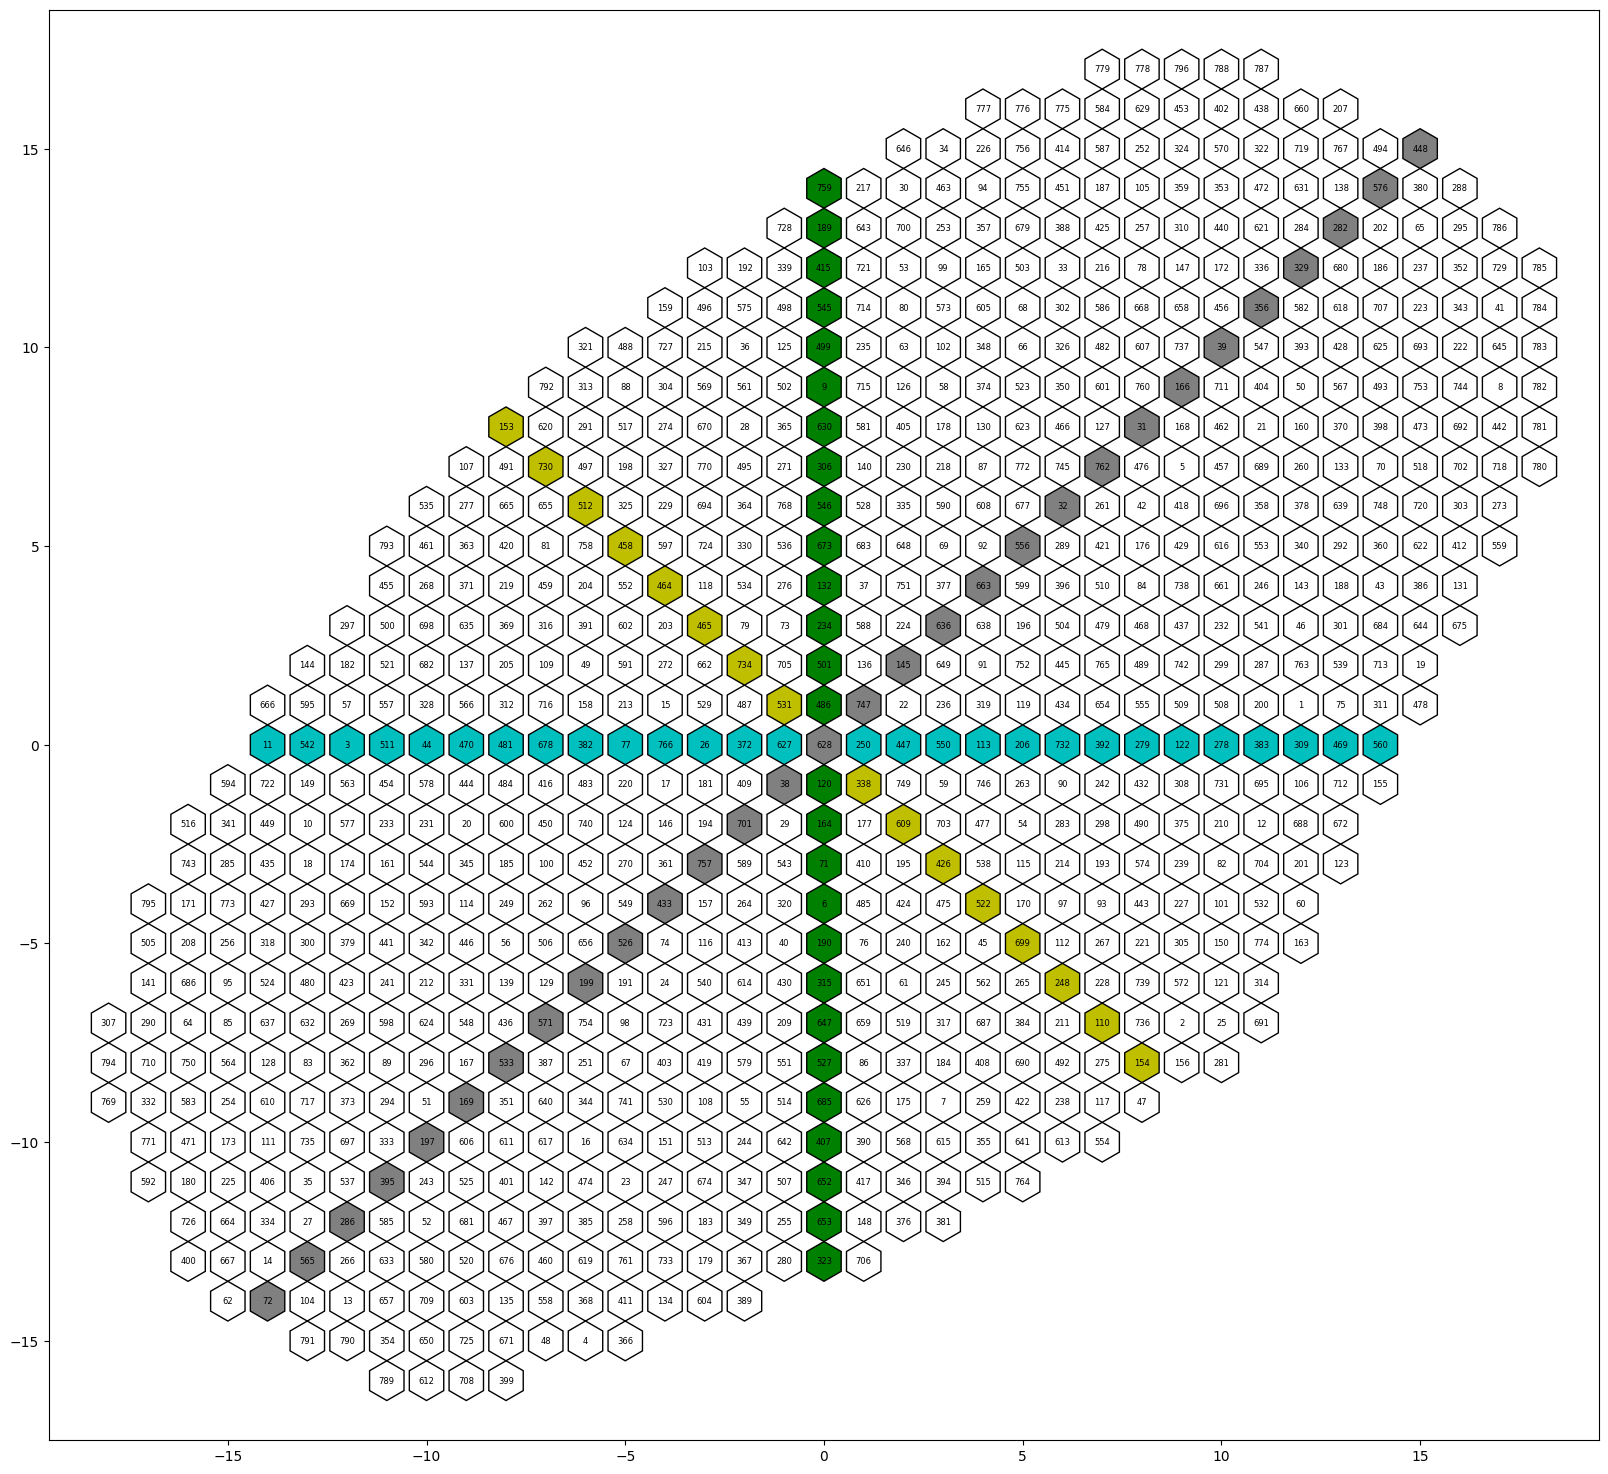

In [94]:
## Plotting on the 2D lattice: check access to each point and axis
fig, ax, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
for p_x, p_y in p:
    color_in_p = p_x
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('g')

for q_x, q_y in q:
    color_in_p = q_x
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            

for h_x, h_y in h:
    color_in_p = h_x
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('y')


for v_x, v_y in v:
    color_in_p = v_x
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('grey')





### Ploting hexagonal grids

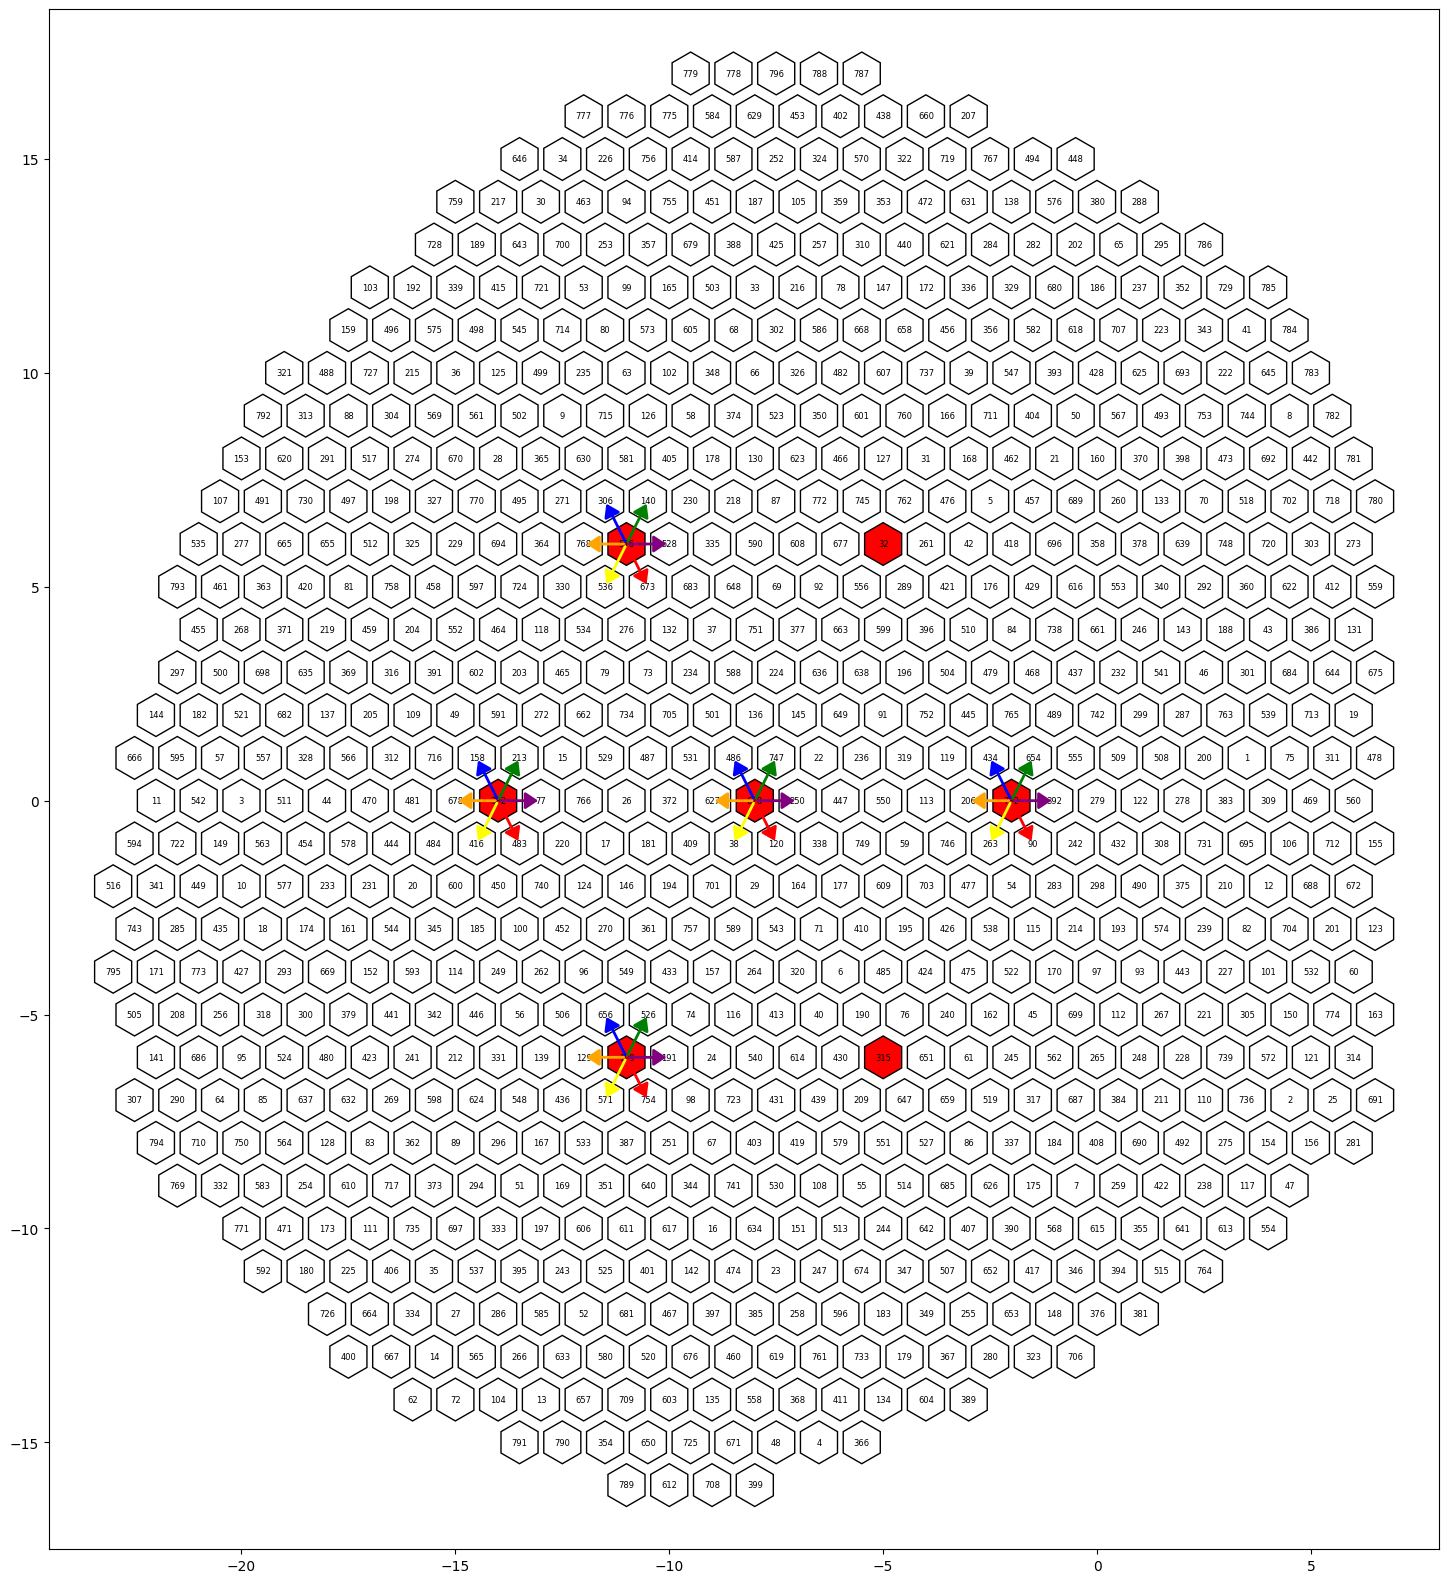

In [31]:
## Plotting on the 2D lattice: check access to each point and axis
original_p = new_p_values
fig, ax, hexagons = plot_hex_grid(new_p_values, original_q, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition

color_in_p = 0
color_in_q = 0
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 0
color_in_q = 6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 0
color_in_q = -6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 6
color_in_q = 0
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = -6
color_in_q = 0
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = 6
color_in_q = 6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

color_in_p = -6
color_in_q = -6
for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
    new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
    if x_pos == new_p_pos[0] and y_pos == color_in_q:
        hexagon.set_facecolor('red')

# Draw vector from hexagon to hexagon
# Choose column_ids
start_ids = ([628]*6) + ([546]*6) + ([732]*6) + ([382]*6) + ([199]*6)
end_ids = [120, 486, 747,38,250,627] + [673,306,140,536,528,768] + [90,434,654,263,392,206] + [483,158,213,416,77,678] + [754,656,526,571,191,129]
color_ls = ["red", "blue", "green", "yellow", "purple", "orange"]*5
start_coords_ls = []
end_coords_ls = []
for start_id, end_id in zip(start_ids, end_ids):
    start_id_p = df_grid[df_grid.column_id == str(start_id)].new_p.values[0]
    start_id_q = df_grid[df_grid.column_id == str(start_id)].q.values[0]
    start_coords_ls.append((start_id_p,start_id_q))

    
    end_id_p = df_grid[df_grid.column_id == str(end_id)].new_p.values[0]
    end_id_q = df_grid[df_grid.column_id == str(end_id)].q.values[0]
    end_coords_ls.append((end_id_p,end_id_q))

    #Drawing vectors
i = 0
for start_coord, end_coord in zip(start_coords_ls,end_coords_ls):
    # Find the coordinates of the start and end hexagons
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    x_end = end_coord[0]
    y_end = end_coord[1]

    draw_vector(ax, x_start, y_start, x_end, y_end, color=color_ls[i])
    #print(f'Color: {color_ls[i]}, end: ({x_end},{y_end})')
    i += 1
    


plt.show()

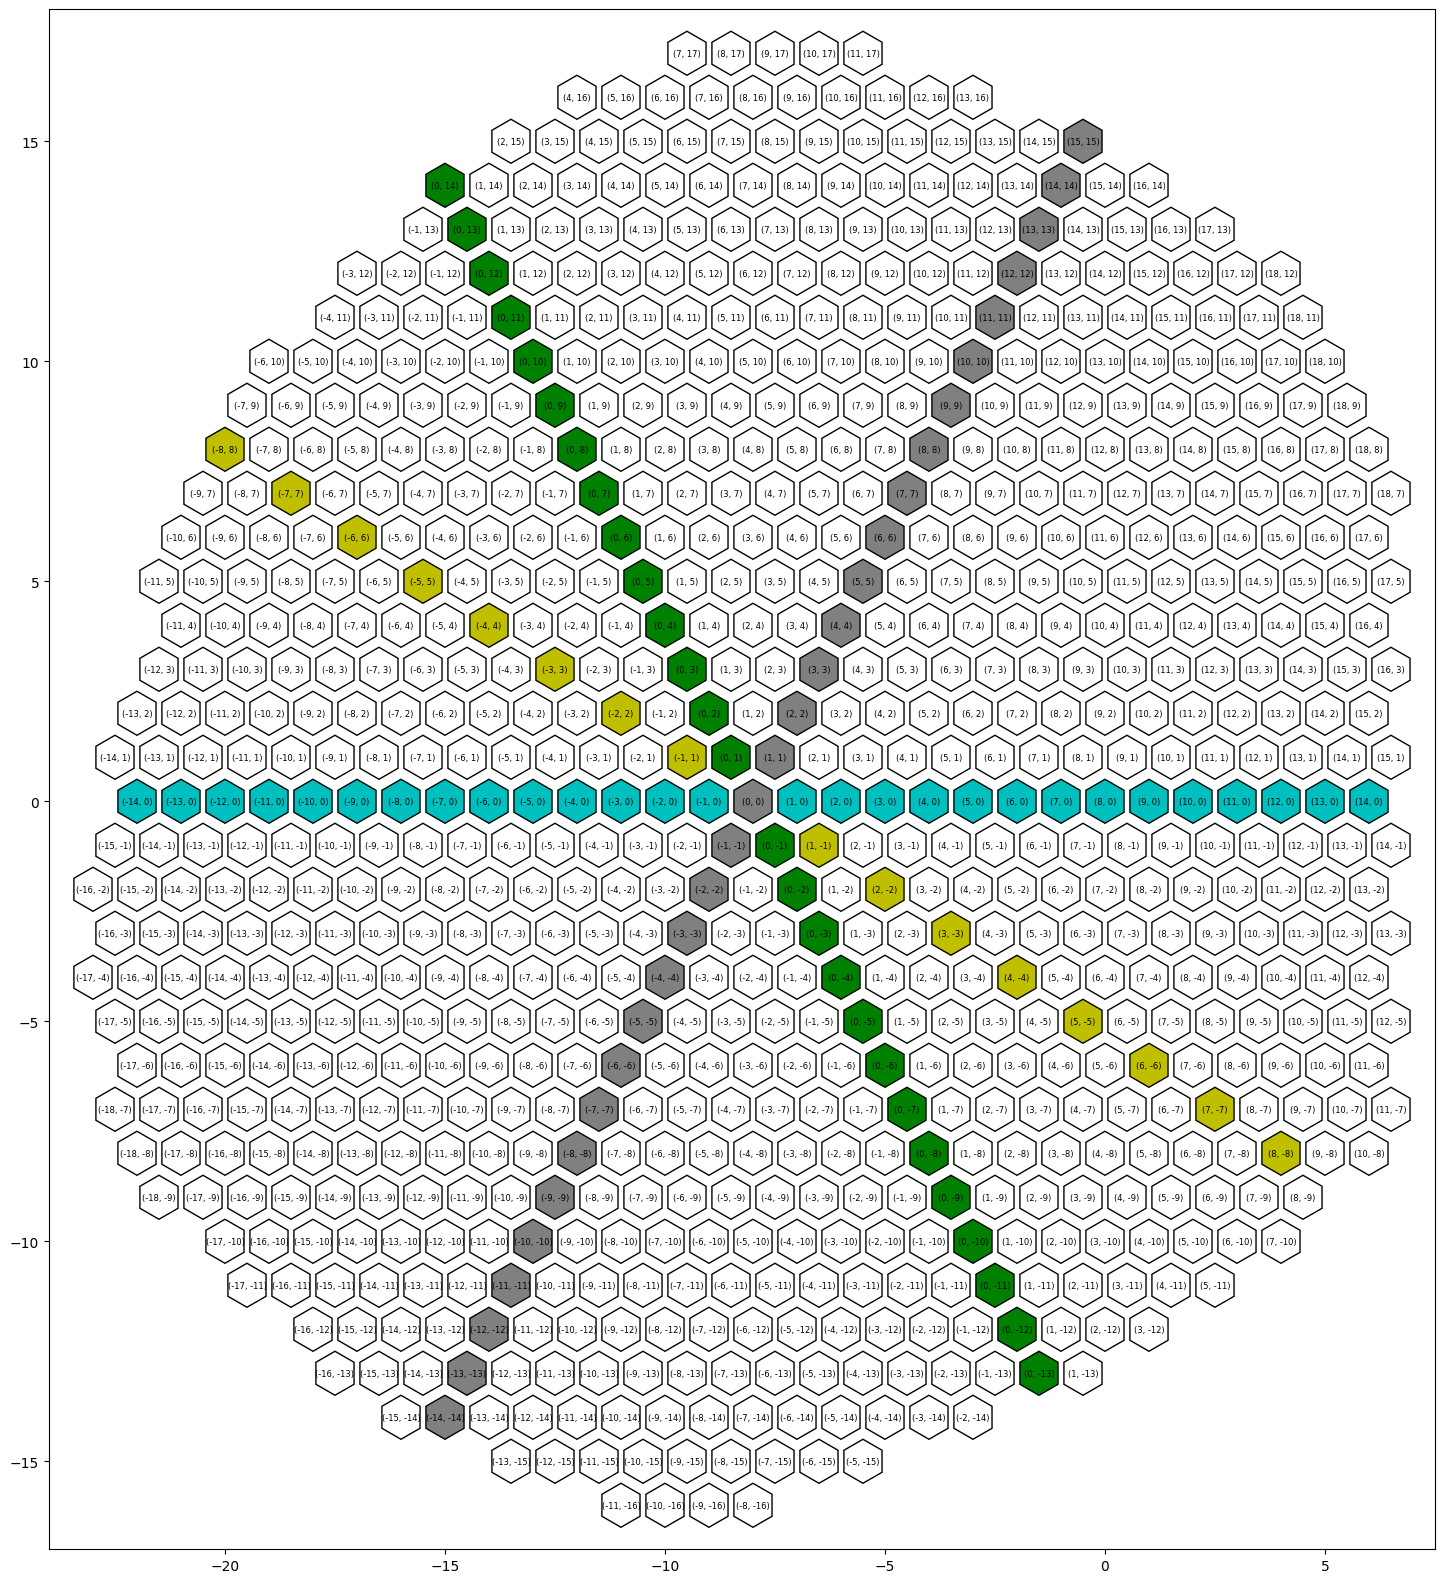

In [14]:
## Plotting on the 2D lattice: look at the reference axis (h, v, p, q) 
fig, ax, hexagons = plot_hex_grid(new_p_values, original_q, hex_size=0.5, spacing=0.5, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
new_p_x_ls = []
for p_x, p_y in p:
    color_in_p = p_x
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('g')
            new_p_x_ls.append(new_p_pos[0])
            
new_q_x_ls = []
for q_x, q_y in q:
    color_in_p = q_x
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            new_q_x_ls.append(new_p_pos[0])
            
new_h_x_ls = []
for h_x, h_y in h:
    color_in_p = h_x
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('y')
            new_h_x_ls.append(new_p_pos[0])

new_v_x_ls = []
for v_x, v_y in v:
    color_in_p = v_x
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('grey')
            new_v_x_ls.append(new_p_pos[0])
            
# Draw reference lines

'''
Needed? I am showing them now by coloring the hexagons
'''


plt.show()

# 4. Plotting optic flow data on the grid/lattice

The logic is to obtain:
1) the home column based on column_id assignment, 
2) the column_id of the highly connected intracolumnar input cells via absolute synaptic counts
3) draw vectors to/from home column from/to those input-cell columns

In [156]:
## Be aware that these two initial data frames do not have the same unique IDs
## Ideally they should. Think of replacing the one that has less

print(f'"connections" df length: {len(connections.to_cell_id.unique())}')
print(f'"columns_id_data" df length: {len(columns_id_data.root_id.unique())}')

"connections" df length: 22824
"columns_id_data" df length: 23452


In [199]:
## Getting inputs of the cell of interest
from_cell_of_interest = 'Mi4'
to_cell_of_interest = 'T4d'



cell_of_interest_inputs = connections_extended[(connections_extended.to_cell_type == to_cell_of_interest) & (connections_extended.from_cell_type == from_cell_of_interest)].copy()
print(len(cell_of_interest_inputs[cell_of_interest_inputs.to_cell_type == to_cell_of_interest].to_cell_id.unique()))
cell_of_interest_inputs_sorted = cell_of_interest_inputs.sort_values(by='to_cell_id')

# Sort by to_cell_id and synapses in descending order
cell_of_interest_inputs_sorted = cell_of_interest_inputs_sorted.sort_values(by=['to_cell_id', 'synapses'], ascending=[True, False])

# Group by to_cell_id and take the first row for each group (highest synapse value)
unique_highest_inputs = cell_of_interest_inputs_sorted.drop_duplicates(subset='to_cell_id', keep='first')

#Dropping 'not assigned' rows
unique_highest_inputs_filtered = unique_highest_inputs[unique_highest_inputs.to_column_id != 'not assigned'].copy()

# Find the duplicates with the same to_cell_id and synapse value
duplicates_in_highest_inputs = cell_of_interest_inputs_sorted[cell_of_interest_inputs_sorted.duplicated(subset=['to_cell_id', 'synapses'], keep=False)]

# Display the resulting data frames
print("Unique Highest Inputs:")
print(unique_highest_inputs.head())
print(f'\n"unique_highest_inputs" df length: {len(unique_highest_inputs)}')

#print("\nDuplicates in Highest Inputs:")
#print(duplicates_in_highest_inputs.head())
#print(len(duplicates_in_highest_inputs))

619
Unique Highest Inputs:
              from_cell_id          to_cell_id  synapses from_cell_type  \
35921   720575940613839986  720575940600934665         3            Mi4   
200673  720575940631230275  720575940603498357        10            Mi4   
242138  720575940637856996  720575940603556981        11            Mi4   
210681  720575940632347463  720575940603842476         2            Mi4   
100643  720575940621800630  720575940604436720         3            Mi4   

       from_column_id to_cell_type to_column_id  
35921             591          T4d          203  
200673            635          T4d          219  
242138            521          T4d          268  
210681            717          T4d           83  
100643            142          T4d          142  

"unique_highest_inputs" df length: 619


In [200]:
## Preparing grid to plot

# Given coordinates and labels (data)
# Original coordinates
original_p = df_grid.p.tolist()
original_q = df_grid.q.tolist()
# Adjusting p values to get a honeycomb-like grid
new_p_values = calculate_new_p_values(original_p, original_q, start_key=-16, end_key=17, relative_change=0.5)
df_grid['new_p'] = new_p_values

# "manual_labels" column ids
labels = df_grid.column_id.tolist() 
labels = None



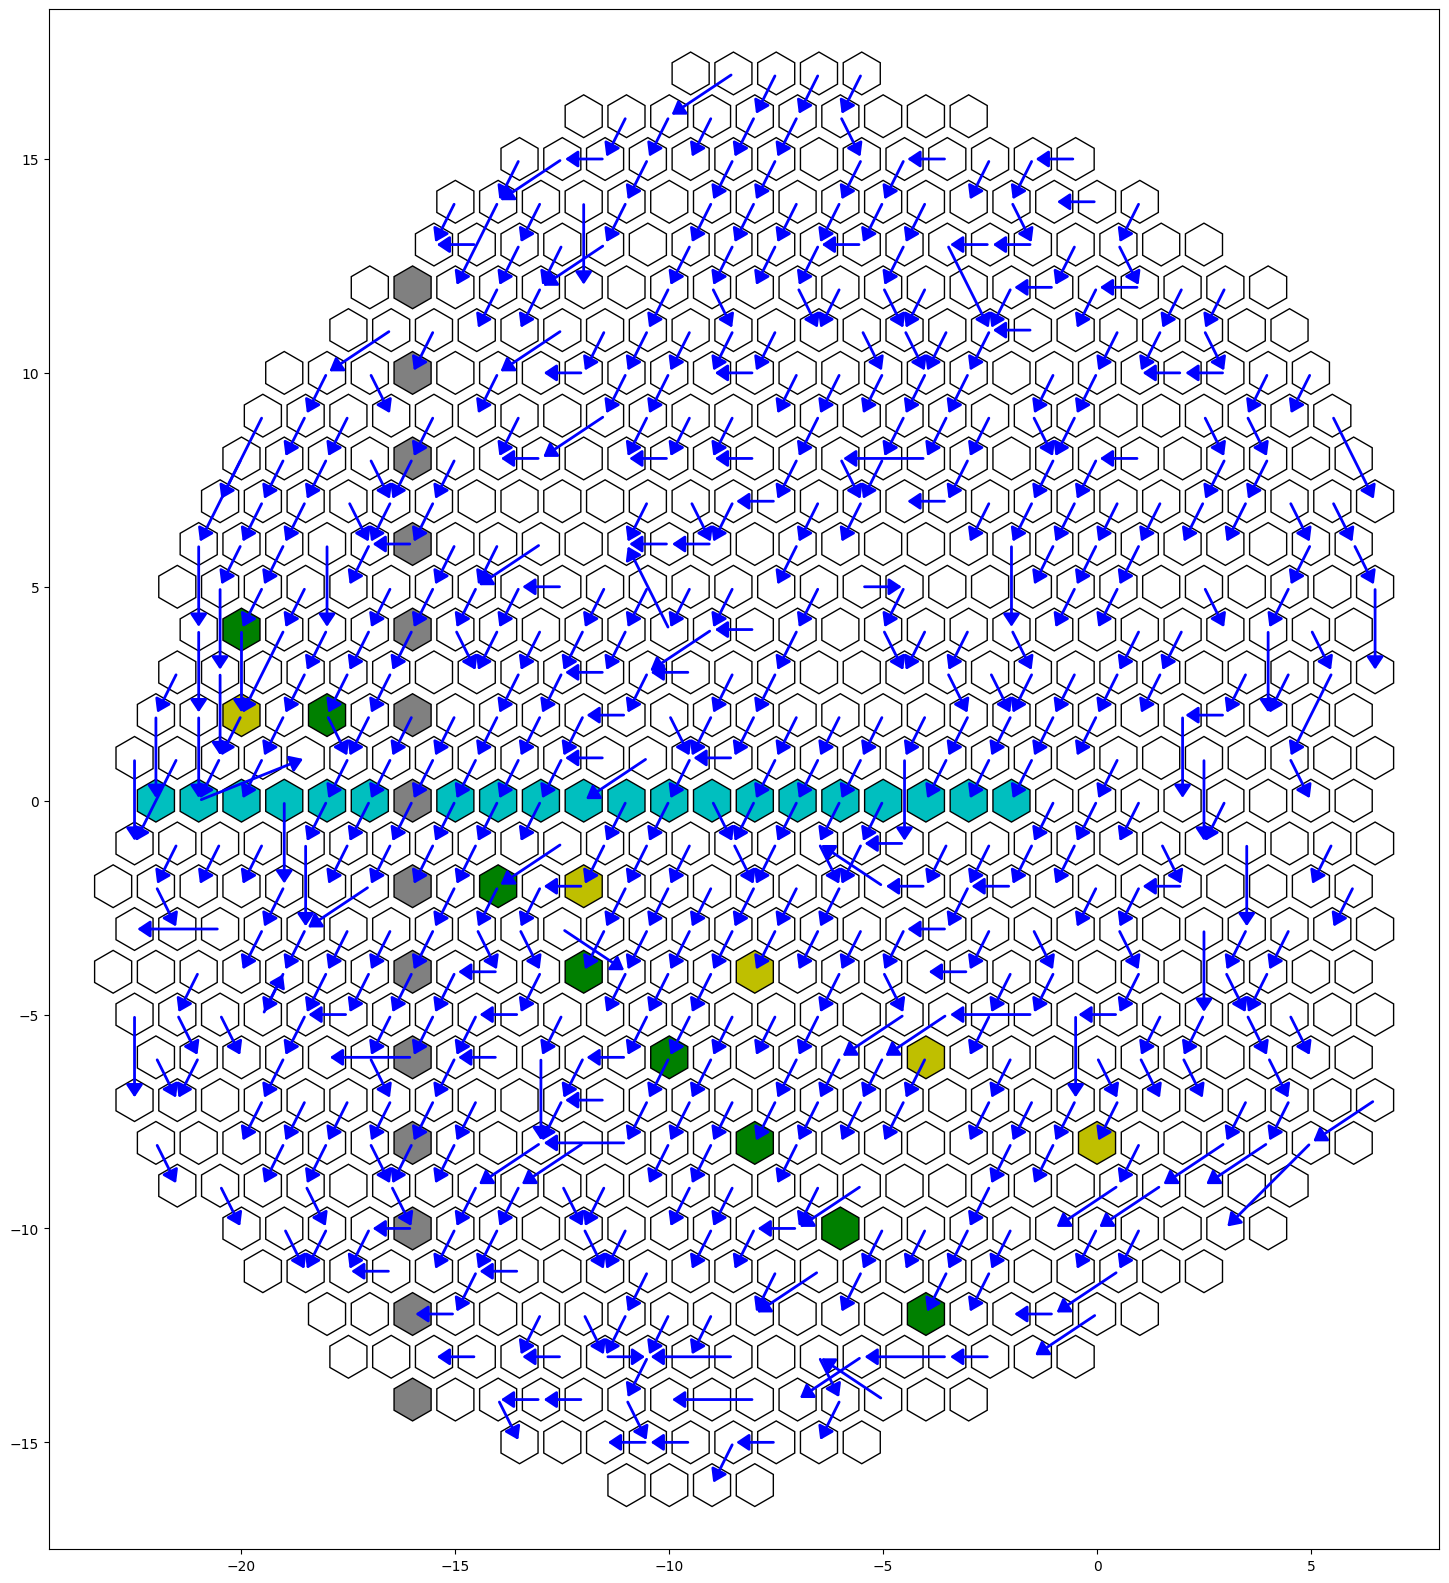

In [201]:
## Plotting on the 2D lattice
fig, ax, hexagons = plot_hex_grid(new_p_values, original_q, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Color-code the different axis:

# Example to color hexagons based on a condition
new_p_x_ls = []
for p_x, p_y in p:
    color_in_p = p_x
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('g')
            new_p_x_ls.append(new_p_pos[0])
            
new_q_x_ls = []
for q_x, q_y in q:
    color_in_p = q_x
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            new_q_x_ls.append(new_p_pos[0])
            
new_h_x_ls = []
for h_x, h_y in h:
    color_in_p = h_x
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('y')
            new_h_x_ls.append(new_p_pos[0])

new_180_0_deg_axis = list(zip(new_h_x_ls,h_y_ls)) # This is my reference line to calculate vectors angles.

new_v_x_ls = []
for v_x, v_y in v:
    color_in_p = v_x
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        new_p_pos = calculate_new_p_values([color_in_p], [y_pos], start_key=-16, end_key=17, relative_change=0.5) # dealing with shifts
        if x_pos == new_p_pos[0] and y_pos == color_in_q:
            hexagon.set_facecolor('grey')
            new_v_x_ls.append(new_p_pos[0])

new_270_90_deg_axis = list(zip(new_v_x_ls,v_y_ls)) # This is my reference line to calculate vectors angles.

# Draw vector from hexagon to hexagon
# Choose column_ids

'''
Ideally the nomenclature must relate: "start_ids"  with "from_column_id" and "end_ids" with "to_column_id"
as written below. However, due to a logic mistake, in a previous step, I run what is written below this comment.
I will need to fix that later. The current fast fix is correct in the analysis.

start_ids = [int(x) for x in unique_highest_inputs_filtered.from_column_id.tolist()]
end_ids = [int(x) for x in unique_highest_inputs_filtered.to_column_id.tolist()]

'''

start_ids = [int(x) for x in unique_highest_inputs_filtered.to_column_id.tolist()]
end_ids = [int(x) for x in unique_highest_inputs_filtered.from_column_id.tolist()] 


start_coords_ls = []
end_coords_ls = []
for start_id, end_id in zip(start_ids, end_ids):
    start_id_p = df_grid[df_grid.column_id == str(start_id)].new_p.values[0]
    start_id_q = df_grid[df_grid.column_id == str(start_id)].q.values[0]
    start_coords_ls.append((start_id_p,start_id_q))

    
    end_id_p = df_grid[df_grid.column_id == str(end_id)].new_p.values[0]
    end_id_q = df_grid[df_grid.column_id == str(end_id)].q.values[0]
    end_coords_ls.append((end_id_p,end_id_q))

#Drawing vectors
for start_coord, end_coord in zip(start_coords_ls,end_coords_ls):
    # Find the coordinates of the start and end hexagons
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    x_end = end_coord[0]
    y_end = end_coord[1]

    draw_vector(ax, x_start, y_start, x_end, y_end, color='b')



plt.show()

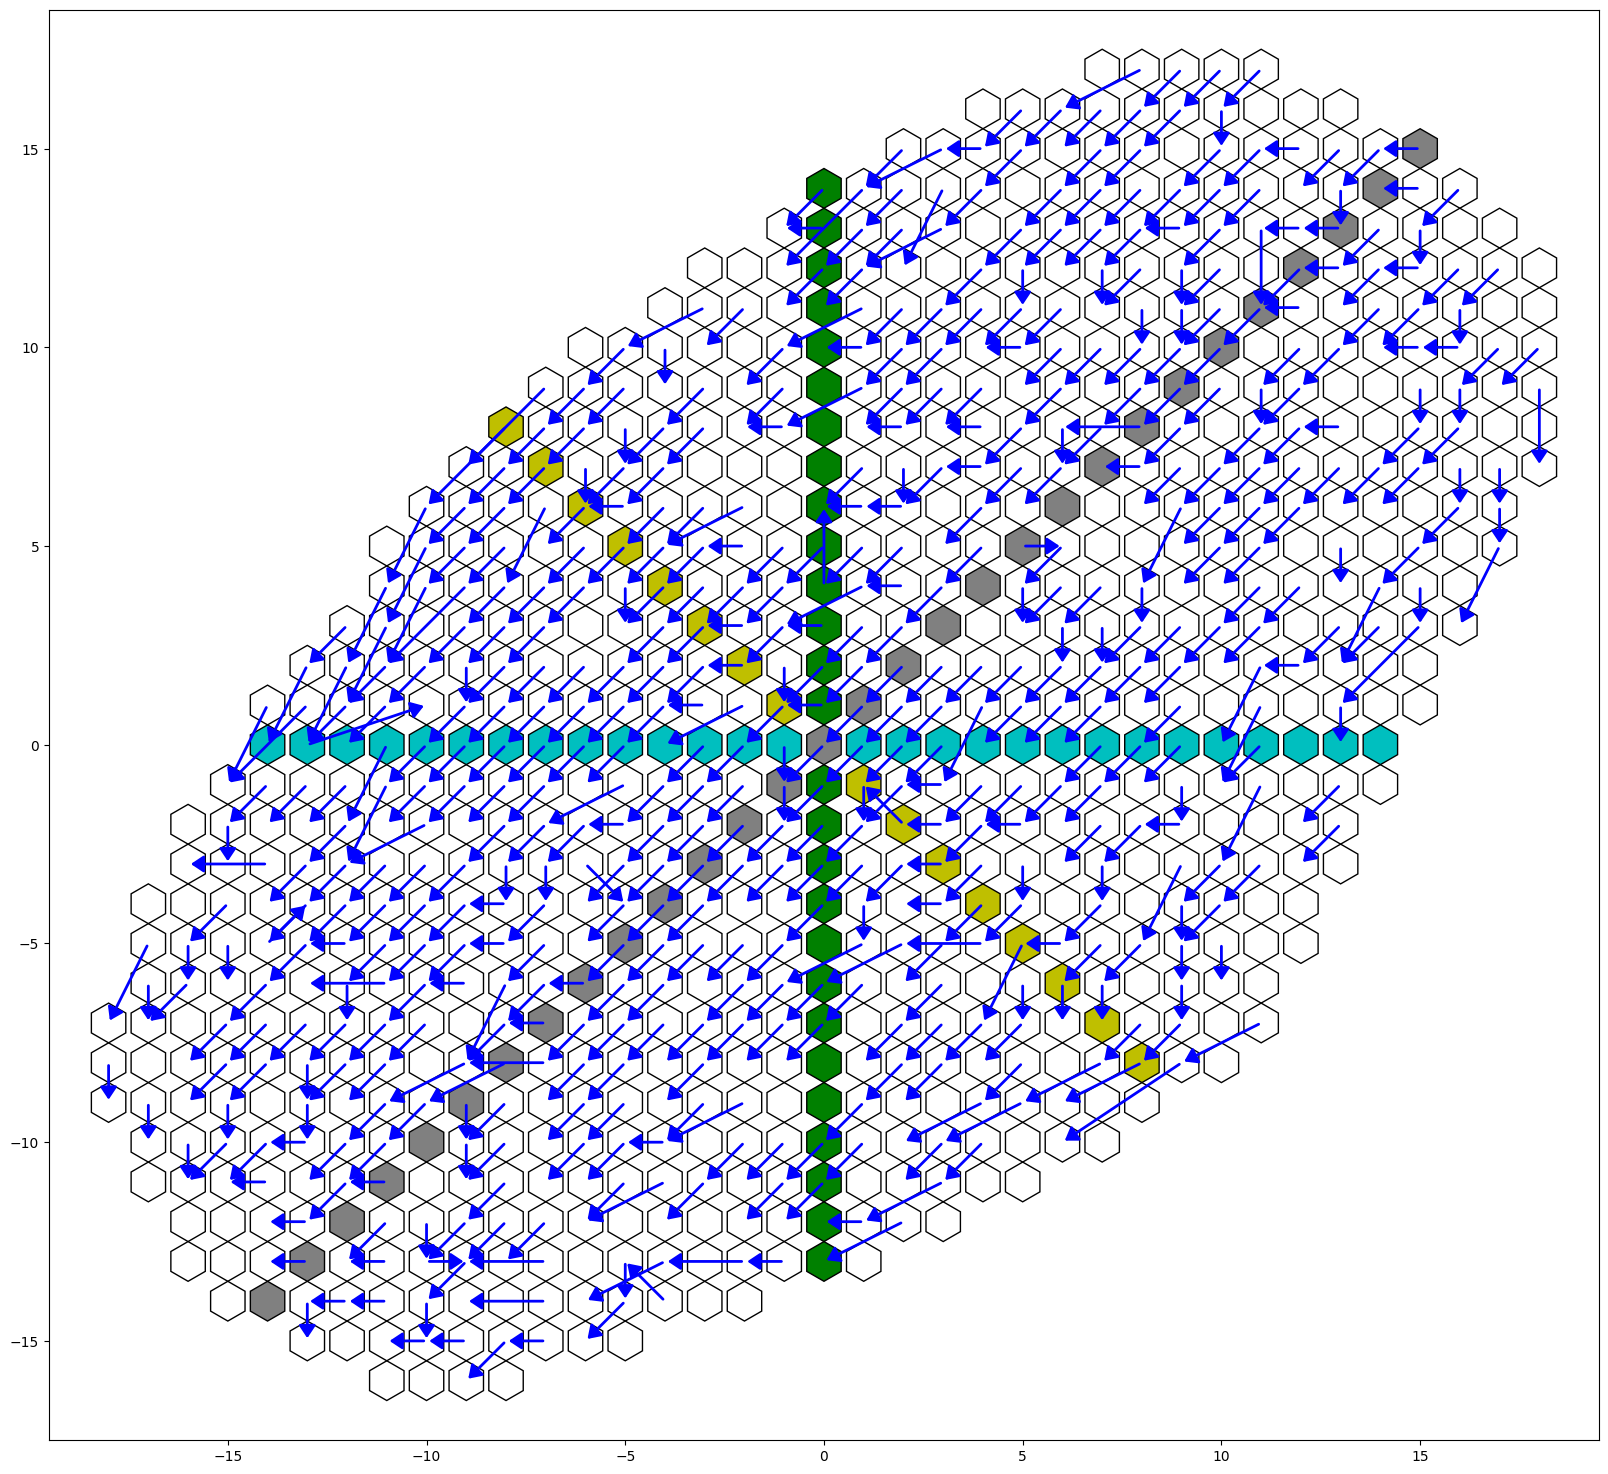

In [202]:
## Plotting on the 2D lattice: check access to each point and axis
fig, ax, hexagons = plot_hex_grid(original_p, original_q, hex_size=0.5, spacing=1.0, fig_size=(20, 20), labels=labels, label_type='manual_labels', text_size=6)

# Example to color hexagons based on a condition
for p_x, p_y in p:
    color_in_p = p_x
    color_in_q = p_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('g')

for q_x, q_y in q:
    color_in_p = q_x
    color_in_q = q_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('c')
            

for h_x, h_y in h:
    color_in_p = h_x
    color_in_q = h_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('y')




for v_x, v_y in v:
    color_in_p = v_x
    color_in_q = v_y
    for hexagon, (x_pos, y_pos) in zip(hexagons, zip(original_p, original_q)):
        if x_pos == color_in_p and y_pos == color_in_q:
            hexagon.set_facecolor('grey')
            


#Preparing the vectors to draw
start_ids = [int(x) for x in unique_highest_inputs_filtered.to_column_id.tolist()]
end_ids = [int(x) for x in unique_highest_inputs_filtered.from_column_id.tolist()] 

start_coords_ls = []
end_coords_ls = []
for start_id, end_id in zip(start_ids, end_ids):
    start_id_p = df_grid[df_grid.column_id == str(start_id)].p.values[0]
    start_id_q = df_grid[df_grid.column_id == str(start_id)].q.values[0]
    start_coords_ls.append((start_id_p,start_id_q))

    
    end_id_p = df_grid[df_grid.column_id == str(end_id)].p.values[0]
    end_id_q = df_grid[df_grid.column_id == str(end_id)].q.values[0]
    end_coords_ls.append((end_id_p,end_id_q))

#Drawing vectors
for start_coord, end_coord in zip(start_coords_ls,end_coords_ls):
    # Find the coordinates of the start and end hexagons
    x_start = start_coord[0]
    y_start = start_coord[1]
    
    x_end = end_coord[0]
    y_end = end_coord[1]

    draw_vector(ax, x_start, y_start, x_end, y_end, color='b')



plt.show()

In [203]:
# Prepare the list for angles
angles = []

# Calculate the angle for each vector
for start_id, end_id, start_coord, end_coord in zip(start_ids, end_ids, start_coords_ls, end_coords_ls):
    # Coordinates
    x_start, y_start = start_coord
    x_end, y_end = end_coord
    
    # Calculate the change in coordinates
    dx = x_end - x_start
    dy = y_end - y_start
    
    # Calculate the angle in radians
    angle_rad = np.arctan2(dy, dx)
    
    # Convert to degrees
    angle_deg = np.degrees(angle_rad)
    
    # Normalize the angle to be in the range [0, 360) degrees
    angle_deg = (angle_deg + 360) % 360
    
    # Append the result to the angles list
    angles.append((start_id, end_id, angle_deg))

# Create a DataFrame with the results
angles_df = pd.DataFrame(angles, columns=['start_id', 'end_id', 'angle'])

# Display the DataFrame
print(angles_df)


     start_id  end_id       angle
0         203     591  225.000000
1         219     635  225.000000
2         268     521  243.434949
3          83     717  270.000000
4         142     142    0.000000
..        ...     ...         ...
589        75     469  270.000000
590       586     586    0.000000
591        66     348  180.000000
592       455     182  243.434949
593       272     213  225.000000

[594 rows x 3 columns]


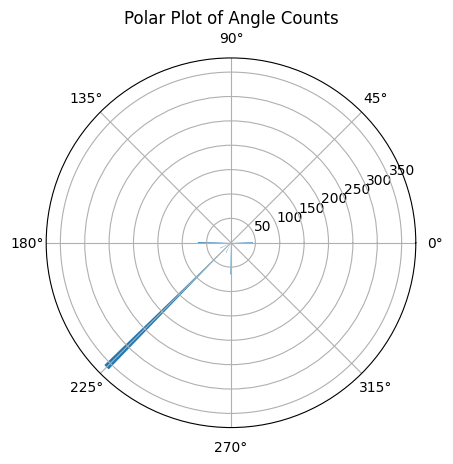

In [204]:
## Plotting frequency

# Drop NaN values from angles
angles_df = angles_df.dropna(subset=['angle'])

# Count the occurrences of each unique angle
angle_counts = angles_df['angle'].value_counts().reset_index()
angle_counts.columns = ['angle', 'count']

# Convert angles to radians
angle_counts['angle_rad'] = np.radians(angle_counts['angle'].values)

# Plotting
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Plot the counts at the corresponding angles
ax.bar(angle_counts['angle_rad'], angle_counts['count'], width=np.pi/90, bottom=0.0)

ax.set_title("Polar Plot of Angle Counts")
plt.show()

### Exploring other option for getting to the polar plot

In [145]:
def normalize(vector):
    """Normalize a 2D vector."""
    norm = np.linalg.norm(vector)
    return vector / norm

def construct_transformation_matrix(x_axis_points, y_axis_points):
    """Construct the transformation matrix from given axis points."""
    # Derive the new x-axis and y-axis vectors
    new_x_axis_vector = np.array(x_axis_points[1]) - np.array(x_axis_points[0])
    new_y_axis_vector = np.array(y_axis_points[1]) - np.array(y_axis_points[0])
    
    # Normalize the vectors
    new_x_axis_unit = normalize(new_x_axis_vector)
    new_y_axis_unit = normalize(new_y_axis_vector)
    
    # Construct the transformation matrix
    transformation_matrix = np.array([new_x_axis_unit, new_y_axis_unit]).T
    return transformation_matrix

def transform_point(point, transformation_matrix):
    """Transform a point using the transformation matrix."""
    return np.dot(transformation_matrix, point)

def transform_points(points, transformation_matrix):
    """Transform a list of points using the transformation matrix."""
    return [transform_point(point, transformation_matrix) for point in points]



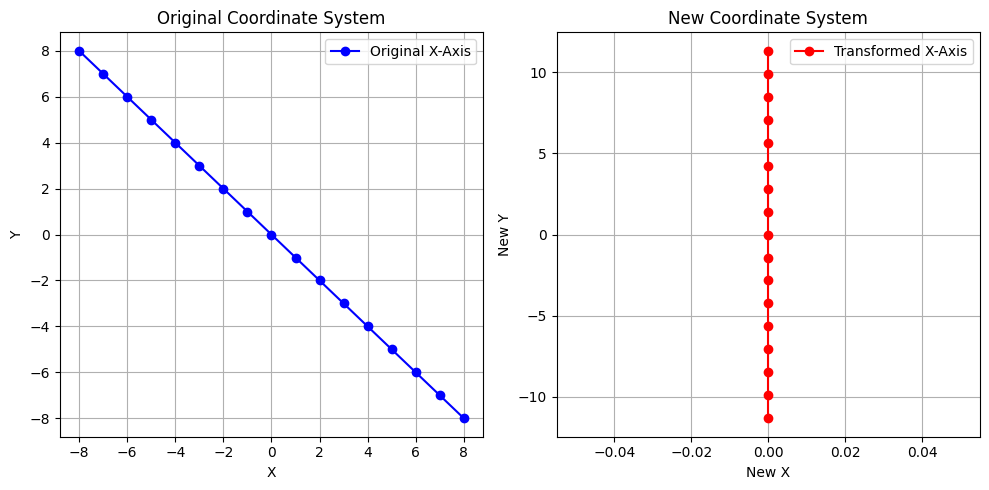

Transformed X-Axis Points:
[ 0.        11.3137085]
[0.         9.89949494]
[0.         8.48528137]
[0.         7.07106781]
[0.         5.65685425]
[0.         4.24264069]
[0.         2.82842712]
[0.         1.41421356]
[0. 0.]
[ 0.         -1.41421356]
[ 0.         -2.82842712]
[ 0.         -4.24264069]
[ 0.         -5.65685425]
[ 0.         -7.07106781]
[ 0.         -8.48528137]
[ 0.         -9.89949494]
[  0.        -11.3137085]


In [146]:
# Example usage:
x_axis_points = [(-8, 8), (-7, 7), (-6, 6), (-5, 5), (-4, 4), (-3, 3), (-2, 2), (-1, 1), (0, 0), (1, -1), (2, -2), (3, -3), (4, -4), (5, -5), (6, -6), (7, -7), (8, -8)]
y_axis_points = [(-14, -14), (-13, -13), (-12, -12), (-11, -11), (-10, -10), (-9, -9), (-8, -8), (-7, -7), (-6, -6), (-5, -5), (-4, -4), (-3, -3), (-2, -2), (-1, -1), (0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15)]

transformation_matrix = construct_transformation_matrix(x_axis_points, y_axis_points)

# Transform the original x-axis points
original_x_axis_points = np.array(x_axis_points)
transformed_x_axis_points = transform_points(original_x_axis_points, transformation_matrix)

# Plot the original and transformed x-axis points
plt.figure(figsize=(10, 5))

# Original coordinate system
plt.subplot(1, 2, 1)
plt.plot(*zip(*original_x_axis_points), marker='o', color='b', label='Original X-Axis')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Coordinate System')
plt.legend()
plt.grid()

# New coordinate system
plt.subplot(1, 2, 2)
plt.plot(*zip(*transformed_x_axis_points), marker='o', color='r', label='Transformed X-Axis')
plt.xlabel('New X')
plt.ylabel('New Y')
plt.title('New Coordinate System')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Print transformed points for verification
print("Transformed X-Axis Points:")
for pt in transformed_x_axis_points:
    print(pt)